<a href="https://colab.research.google.com/github/ss-shrishi2000/PUBG-Finish-Placement-Prediction-Data/blob/main/PUBG_Finish_Placement_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

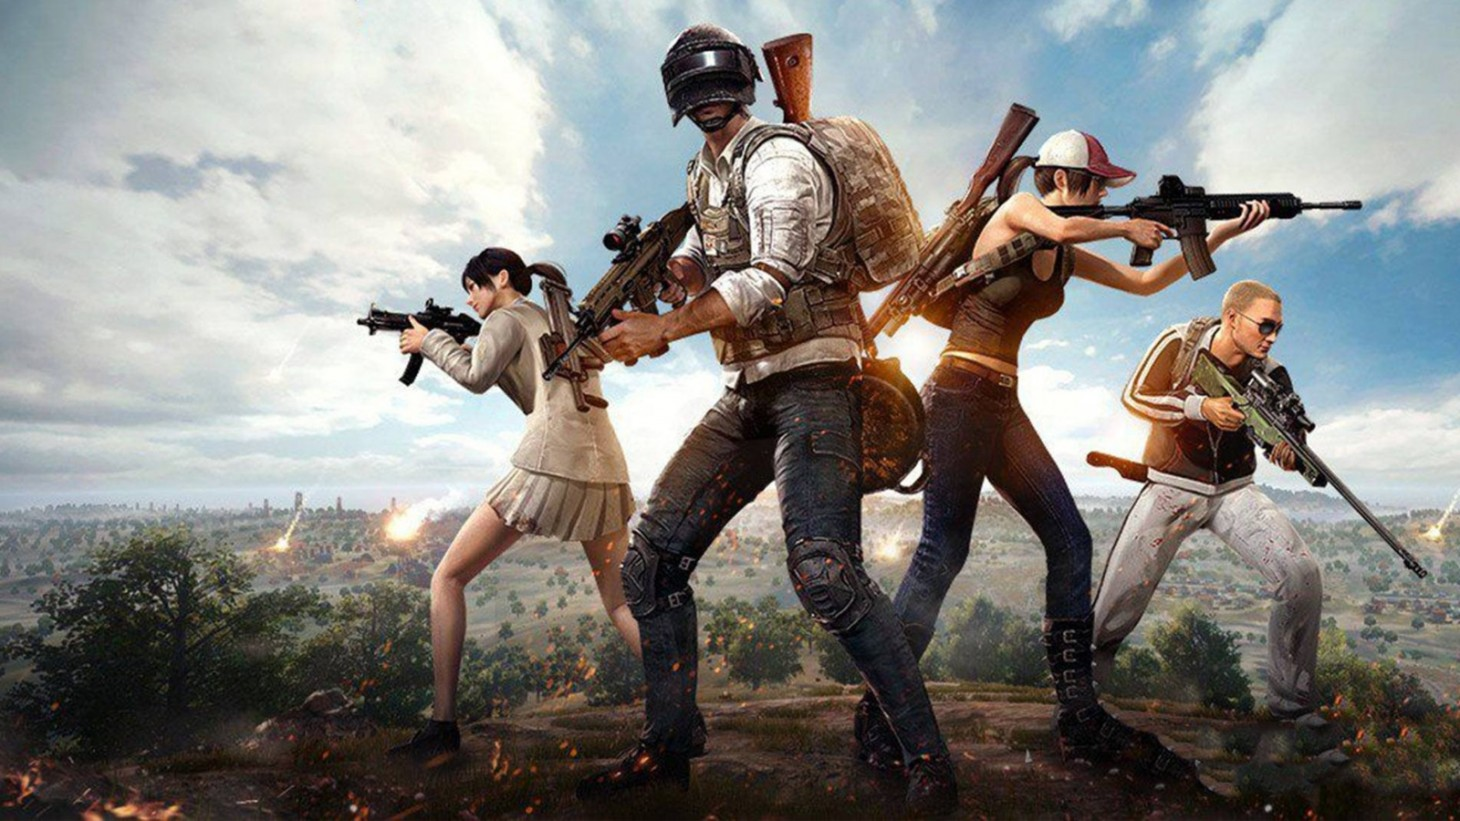

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':'1jGV7eKKWux-BeXAL7GuTVj1gVgzyZWdi'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train_V2.csv') 

In [6]:
downloaded2 = drive.CreateFile({'id':'1VpMuHE1mWXbmmaszQMY3oPSJJvQOUoXj'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test_V2.csv') 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**PROBLEM STATEMENT =>**
We are provided with a large number of anonymized PUBG Game Statistics. Each row contains one player's finishing placement based on their final statistics, on a scale from 1(first place) to 0(last place).
<br>


---

*   How can we catch Cheaters in the Game?
*   What are the most necessary features while making the prediction for winning the Game?
*   Does killing more people increases the chances of winning the game?
*   How does total distance travelled by the player impacts the win of the player?  

*   How to catch the Presence of outliers in the game?

**Salient Features About The Game**


1.   Each Player has their own PlayerID.
2.   Each Match has It's MatchID.
3.   If the Players play in Groups, they have a GroupID. The ID'S get ranked at the end of each Game, depending upon the number of alive people at the end of the Game.

The Exploratory Data Analysis of the Dataset shall answer the above questions in our Problem Statement.






In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")

#**Data Cleaning And Loading =>**
Making the use of the complete Dataset shall heavily affect the performance of the system. Therefore, it becomes imperative to make our dataset smaller without losing essential data items of our dataset.
<br>
> The method shall involve traversing over every column in the Dataset and checking if the column type is numeric.
<br>
We apply the smallest datatype possible to fit the complete range of values.






In [11]:
def reduce_mem_usage(df):
    """ iterating through all the columns of a dataframe and modify the data type to reduce cumbersome memory usage """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#**Output Of the Above Code** 
### returns a Dataframe Where the enormous amount of data has been reduced to half of it's size with minimum loss of information.

##**Reference** => The above code has been taken up from [Kaggle](https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook) 



In [12]:
train = pd.read_csv('train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 452.07 MB
Decreased by 54.1%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 201.94 MB
Decreased by 51.1%
(4446966, 29) (1934174, 28)


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               category
 1   groupId          category
 2   matchId          category
 3   assists          int8    
 4   boosts           int8    
 5   damageDealt      float16 
 6   DBNOs            int8    
 7   headshotKills    int8    
 8   heals            int8    
 9   killPlace        int8    
 10  killPoints       int16   
 11  kills            int8    
 12  killStreaks      int8    
 13  longestKill      float16 
 14  matchDuration    int16   
 15  matchType        category
 16  maxPlace         int8    
 17  numGroups        int8    
 18  rankPoints       int16   
 19  revives          int8    
 20  rideDistance     float16 
 21  roadKills        int8    
 22  swimDistance     float16 
 23  teamKills        int8    
 24  vehicleDestroys  int8    
 25  walkDistance     float16 
 26  weaponsAcquire

As we can see the above information regarding the dataset, we have 28 columns in our Training Data Set with their Datatypes given on the right-hand side.

In [14]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


### The Command **train.head()** prints the first 5 rows of the Dataset. If we use the command **train.tail()**, it would print the bottom 5 rows of the Dataset.

In [15]:
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,0,1292.0,0,0.000000,0,0,1019.0000,3,1507,0.178589
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,0,0.0,0,0.000000,0,0,81.6875,6,0,0.293457
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,0,0.0,0,2.183594,0,0,788.5000,4,0,0.481445
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,2,0.0,0,0.000000,0,0,2748.0000,8,0,0.799805
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00000,0,0,1,18,...,0,1369.0,0,0.000000,0,0,1244.0000,5,0,0.546387


The training set data comprises of around 4,446,996 rows and 29 columns in the form of a .CSV file. Few of the columns described for the Exploratory Data Analysis of our data is given below :-

*   **groupId** - An integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupID each time.
*   **assists** - The total number of times a person helped their friend when he/she killed an enemy.
*   **boosts** - Number of boost items used.
Energy Boosters definately can add on to the performance of the player and can surely contribute to our Analysis.





#**OUTLIERS DETECTION AND ANOMALIES**
No dataset is ever 100% clean and even this dataset is no different.

Some of the data might not reflect the core gameplay because it is drawn from custon game modes or because it has fraudsters. Some of the characterictics of this anomalous data includes the following :-


*   Many kills without moving much
*   Suspiciously high number of kills

*   Suspiciously long range kills
*   Many roadkills while travelling a very short distance.

In [16]:
for i in ['Id','groupId','matchId']:
  print(f'unique[{i}] count:', train[i].nunique())

unique[Id] count: 4446966
unique[groupId] count: 2026745
unique[matchId] count: 47965


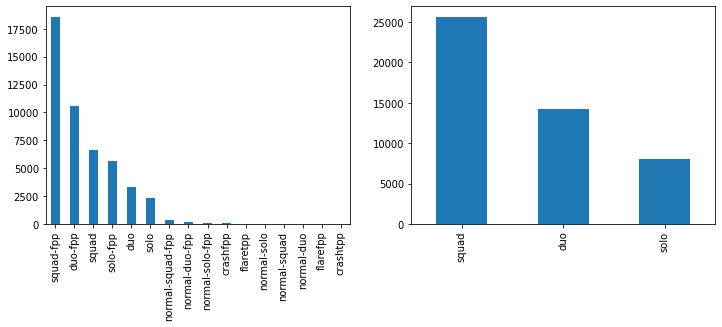

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])
mapper = lambda x:'solo' if ('solo' in x ) else 'duo' if ( 'duo' in x ) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

**groupby()** is a very powerful function with a lot of variations. It makes the task of splitting the dataframe over some criteria really easy and efficient.



#**Player Analysis**


*   Players in match and group
*   During a Game 100 players can join the same server, so in case of duos the max teams are 50 and in case of squads the max teams allowed are 25.



In [18]:
subset = train[train['matchId']=='3e029737889ce9']
subgroup = subset[subset['groupId']=='b8275198faa03b']
print('-'*50)
print('players:', len(subset))
print('groups:', subset['groupId'].nunique())
print('numGroups:', subset['numGroups'].unique())
print('maxPlace:', subset['maxPlace'].unique())
print('-'*50)
print('max-group players:', len(subgroup))
print('max-group winPlacePercentile:',subgroup['winPlacePerc'].unique())
print('-'*50)
print('winPlacePercentile:',subset['winPlacePerc'].sort_values().unique())

--------------------------------------------------
players: 99
groups: 14
numGroups: [14]
maxPlace: [50]
--------------------------------------------------
max-group players: 72
max-group winPlacePercentile: [0.2449]
--------------------------------------------------
winPlacePercentile: [0.     0.0204 0.0408 0.0612 0.0816 0.102  0.1224 0.1633 0.1837 0.2041
 0.2245 0.2449 0.5103 1.    ]


#**Correlation Of The Features with Winning Percentile**

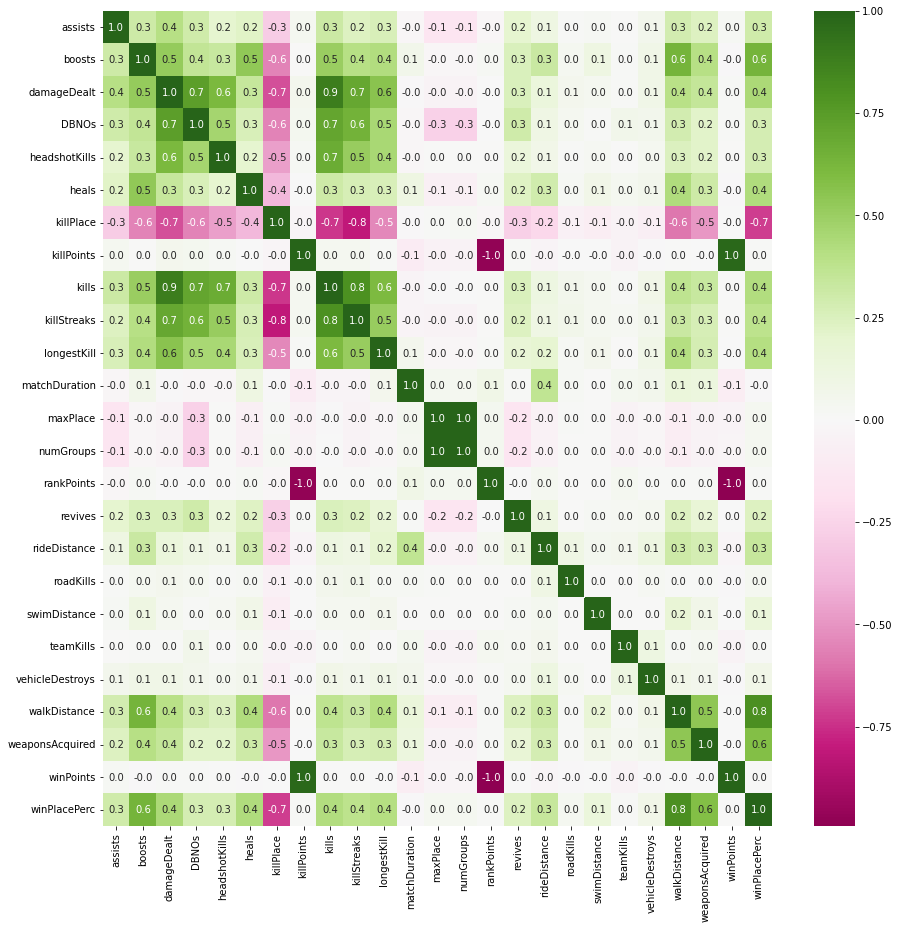

In [19]:
corr = train.corr()
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.corr(), annot=True, fmt='.1f', ax=ax, cmap="PiYG")
sns.set(font_scale=1)
plt.show()

#**FEATURE ENGINEERING**
It is the process with the help of which existing attributes of data is used to create new attributes(features), that can be used to train a predictive model.

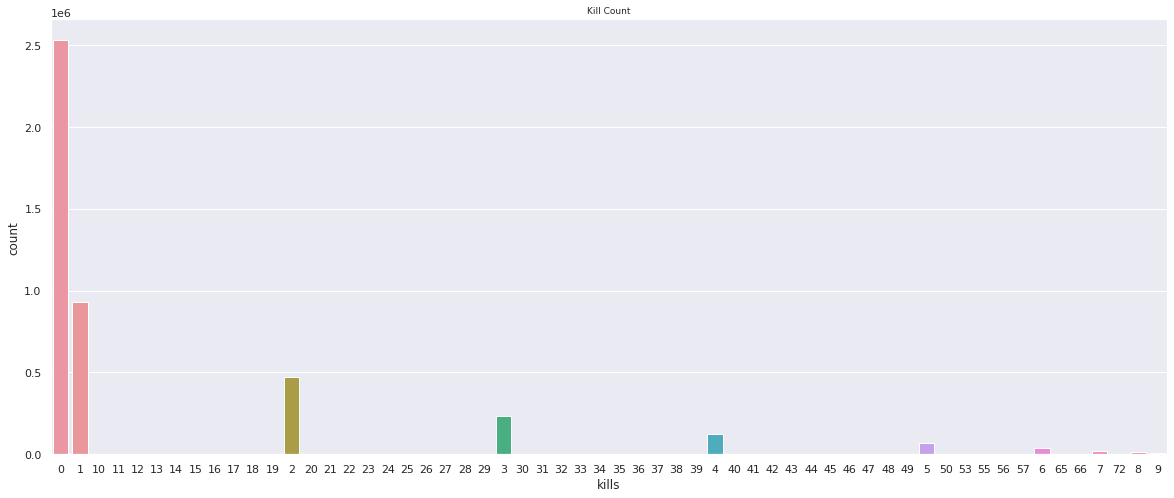

In [20]:
data = train.copy()

plt.figure(figsize = (20,8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize = 9)
plt.show()

### Majority Of the people couldn't deal with even a single kill. There might be some damage they would have given to the other soldiers.

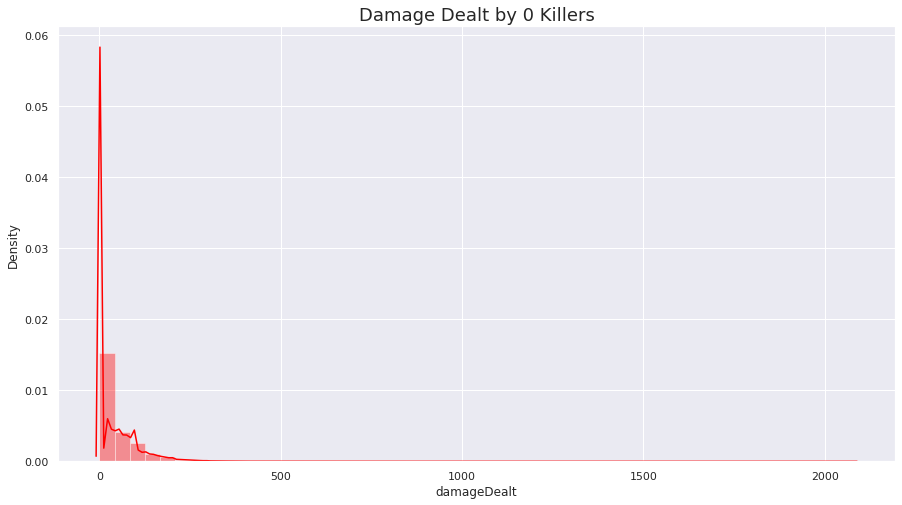

In [21]:
data = train.copy()
data = data[ data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 Killers", fontsize=18)
sns.distplot(data['damageDealt'],color="red")
plt.show()

#**Effect Of Killing On Winning Percentage=>**
As shown below by the increasing mean of win percentage placement, we found that the kill count was correlated with our target variable, which makes sense because more kills usually means a player is more skilled and has a better rank.

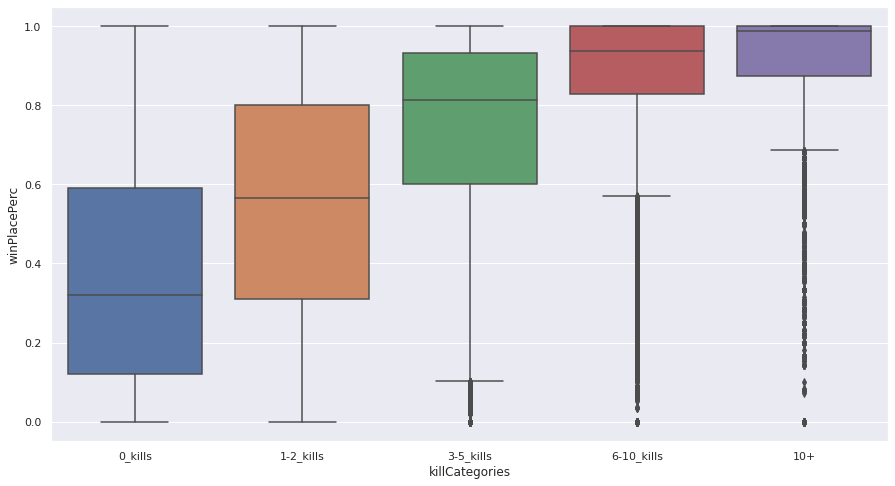

In [22]:
kills = train.copy()
kills['killCategories'] = pd.cut(kills['kills'], [-1,0,2,5,10,60], labels = ['0_kills','1-2_kills','3-5_kills','6-10_kills','10+'])
plt.figure(figsize=(15,8))
sns.boxplot(x='killCategories', y='winPlacePerc', data=kills)
plt.show()

### Kills have a really high correlation with winPlacePercentile.

#**Runtime Analysis**


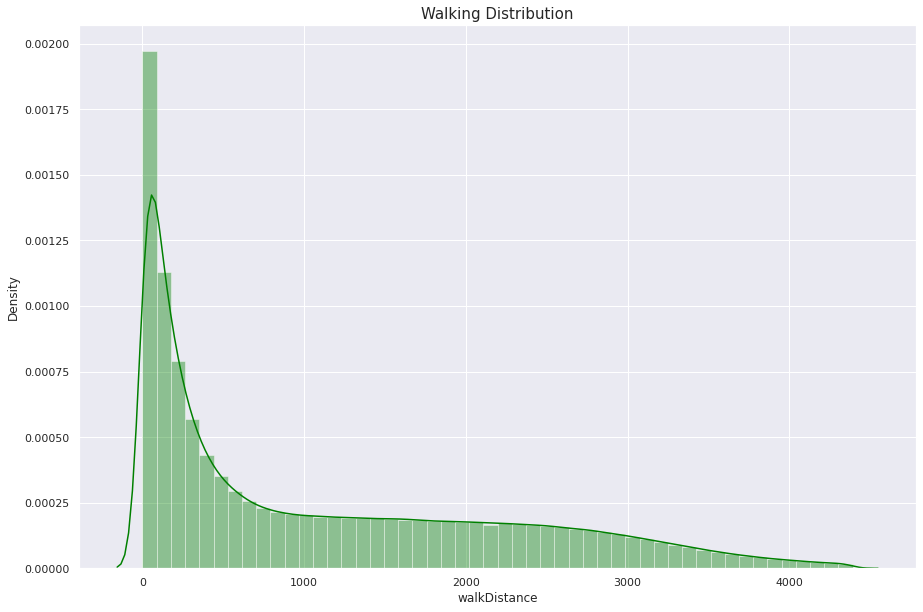

In [23]:
data = train.copy()
data = data[data['walkDistance'] <train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title('Walking Distribution',fontsize=15)
sns.distplot(data['walkDistance'],color="green")
plt.show()

#**Runtime Analysis On Winning Percentile Of A Player**

Here we can make use of scatterplot to show the high correlation between the running and winning percentage. The relation can be stated as => The Longer you are alive, the more you run and the more are your chances of winning. It means u have walked the longest and u r the last man standing, if u have won the game.

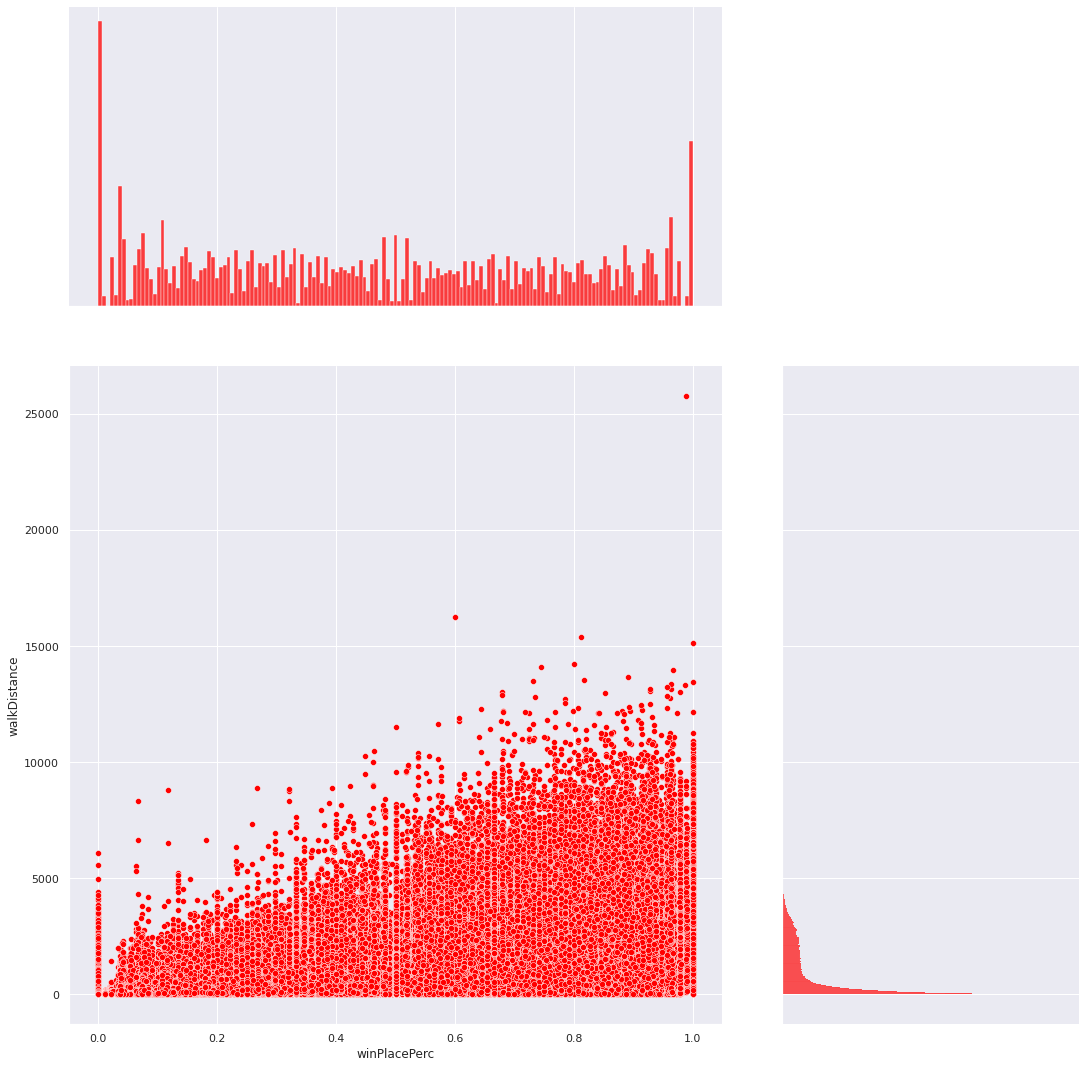

In [24]:
sns.jointplot(x="winPlacePerc", y="walkDistance", data=train, height=15, ratio=2, color="red")
plt.show()

#**Analysing the Riding**



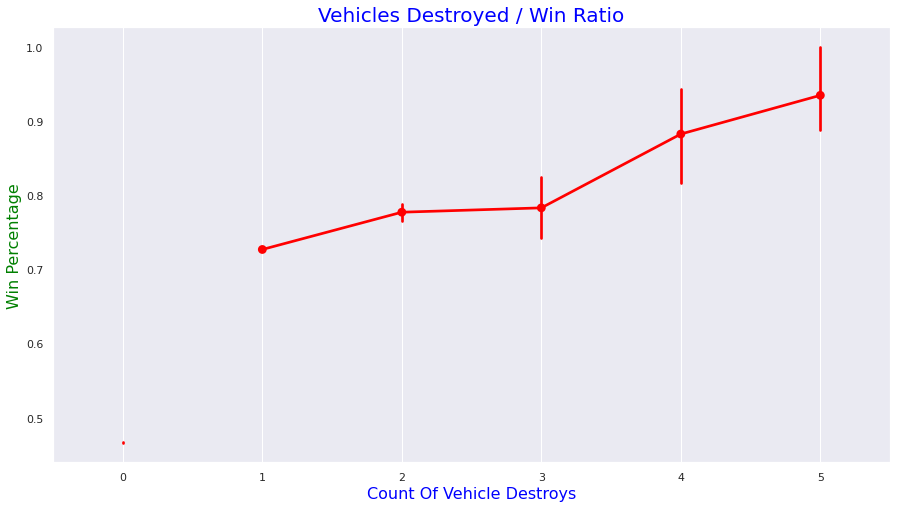

In [25]:
f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='vehicleDestroys', y='winPlacePerc' , data=data, color = 'red', alpha=0.5)
plt.xlabel('Count Of Vehicle Destroys', fontsize = 16, color='blue')
plt.ylabel('Win Percentage' , fontsize = 16, color='green')
plt.title('Vehicles Destroyed / Win Ratio', fontsize = 20, color = 'blue')
plt.grid()
plt.show()

### More or less we can say that the more the number of vehicles getting destoryed, the more is the winning Percentile for a given player.

#**Analysing Healing And Boosting For Players In A Match And Observing their correlation on Winning Percentile**


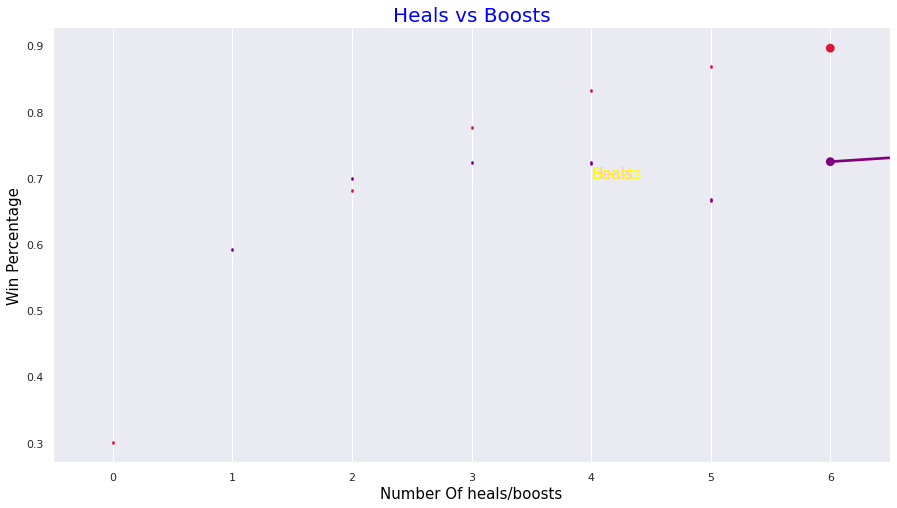

In [26]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]
f,ax1 = plt.subplots(figsize=(15,8))
sns.pointplot(x='heals', y='winPlacePerc', data = data, color='purple', alpha=0.5)
sns.pointplot(x='boosts', y='winPlacePerc', data = data, color='crimson', alpha=0.5)
plt.text(4,0.7,'Heals',color='pink', fontsize=15, style = 'normal')
plt.text(4,0.7,'Boosts',color='yellow', fontsize=15, style = 'normal')
plt.xlabel('Number Of heals/boosts', fontsize = 15, color = 'black')
plt.ylabel('Win Percentage', fontsize = 15, color = 'black')
plt.title('Heals vs Boosts', fontsize = 20, color='blue')
plt.grid()
plt.show()

#**OUTLIER DETECTIONS USING EDA**

An outlier is a value that lies outside of the general pattern of the other values present in a dataset.
For Example:- Amongst the given average marks of 8 students given as => 35,150, 1, 33, 47, 62, 90, 67, both 1 and 150 are outliers for the given data.
Removing outliers helps to make more accurate and improved models.


#**FRAUD DETECTION IN THE GAME**
##Illegal Matches =>

In [27]:
train[train['winPlacePerc'].isnull()]


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [28]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace = True)

In [29]:
train.shape

(4446965, 29)

#**Anomalies In Killing :- Aiming Hacks**

*   Making Use of **Bots** for performing Headshot kills with the highest level of accuracy.
*   A fairly high number of head-shots with minimal **Walking, Riding, Heels, Boosts, etc**, <br> isn't normal and hence we need to remove these Anomalies or Outliers from our dataset.




In [30]:
train['_totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

To detect if there is a presence of an anomaly, we can use the number of **headshot kills** with utmost accuracy with around more than 10 to 15 kills.

In [31]:
train['_headshot_rate'] = train['headshotKills']/train['kills']
train['_headshot_rate'] = train['_headshot_rate'].fillna(0)

In [32]:
def show_countplot(column):
  plt.figure(figsize=(15,8))
  sns.countplot(data=train, x = column).set_title(column)
  plt.show()

def show_distplot(column):
  plt.figure(figsize=(15,8))
  sns.distplot(train[column], bins=50)
  plt.show()

#**Certain Data Anomalies**
1.  Kills with extremely high number of headshot kills.
2.  Kills with extremely low amount of Walk Distance covered.
3.  Kills with no use of heals or boosts throughout the course of the game.





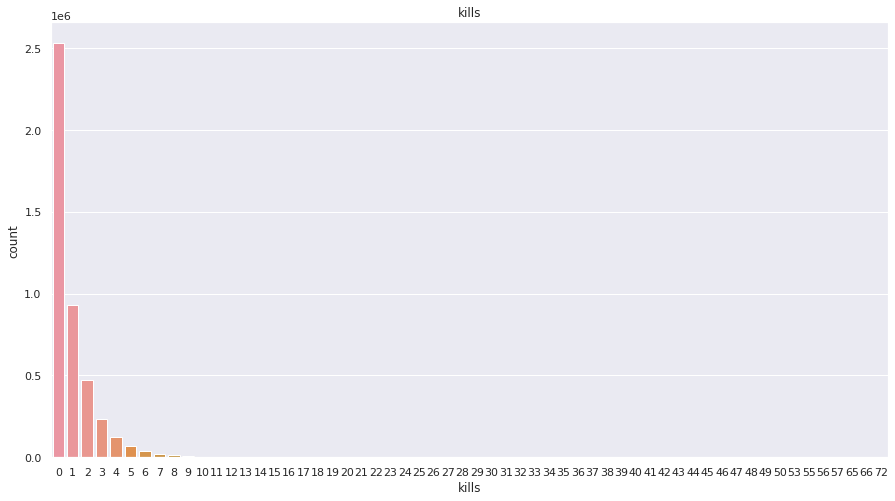

In [33]:
show_countplot('kills')

In [34]:
train[(train['kills'] >= 40 ) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5480.0,0,12,7,4,...,0,0.0,0,0,23.703125,61,0,0.700195,23.703125,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5792.0,0,5,2,1,...,0,0.0,0,0,24.265625,56,0,1.000000,24.265625,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5556.0,0,7,4,1,...,0,0.0,0,0,85.562500,66,0,1.000000,85.562500,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3708.0,0,5,1,5,...,0,0.0,0,0,46.718750,72,0,0.777832,46.718750,0.121951


In [35]:
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4032.0,0,40,0,1,...,0,0.0,1,0,718.500,16,1500,1.0,718.500,0.952381
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,...,0,0.0,0,0,80.375,21,0,1.0,80.375,0.790698
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4104.0,31,3,0,1,...,0,0.0,0,0,1282.000,22,0,1.0,1282.000,0.075000
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4348.0,0,31,0,1,...,0,0.0,0,0,134.250,36,0,1.0,134.250,0.584906
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,...,0,0.0,0,0,1180.000,2,1500,1.0,1180.000,0.875000


In [36]:
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0) ].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0) ].index, inplace=True)

#**Another Anomaly => 100% Headshot Kills**


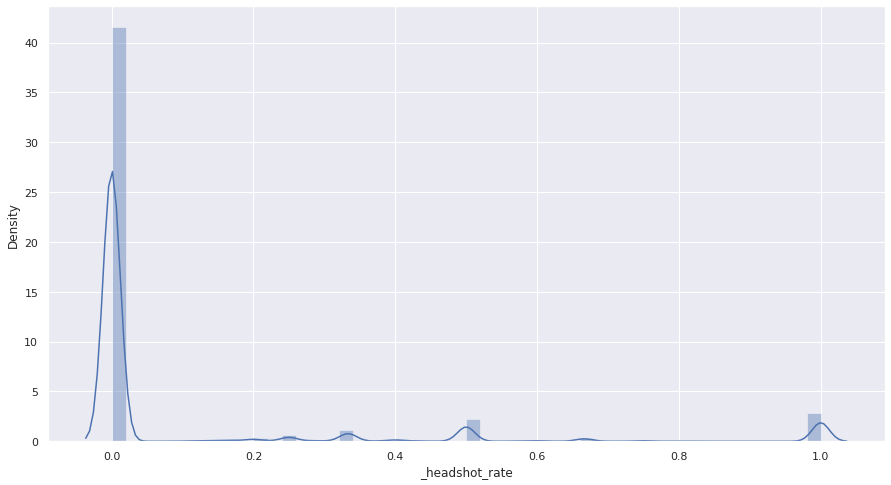

In [37]:
show_distplot('_headshot_rate')

In [38]:
display(train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].shape)
train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0,0.00,0,0,2940.0,5,0,0.846191,2940.0,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,0,0.00,0,0,3422.0,8,1560,1.000000,8144.0,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,0,0.00,0,0,2104.0,5,1587,1.000000,2104.0,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0,0.00,2,0,2760.0,7,1519,0.962891,7948.0,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,0,0.00,0,0,2458.0,4,1562,1.000000,3476.0,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,0,0.00,0,0,2932.0,4,0,1.000000,8180.0,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,0,0.00,0,0,2450.0,7,1468,1.000000,2860.0,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,0,0.00,0,0,3916.0,5,0,1.000000,5964.0,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,0,0.00,0,0,3108.0,7,1500,1.000000,3108.0,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,0,140.75,0,0,2340.0,4,0,1.000000,2480.0,1.0


#**Anomaly => Killing Without Moving**
With very less amount of TotalDistance travelled **(< 50 metres)**, we get outliers when there are very high number of headshot kills and with very high accuracy.

In [39]:
train['_killsWithoutMoving'] = ((train['kills']>0) & (train['_totalDistance'] == 0))
#Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0000,0,0,3,18,...,0.0,0,0,0.0,8,0,0.856934,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.5000,0,0,6,33,...,0.0,0,0,0.0,22,0,0.600098,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0000,0,4,5,3,...,0.0,0,0,0.0,13,0,0.894531,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.7500,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.000000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0000,0,1,0,37,...,0.0,0,0,0.0,10,0,0.300049,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.0000,4,1,3,7,...,0.0,0,0,0.0,8,0,0.799805,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.0000,0,4,1,7,...,0.0,0,0,0.0,8,0,0.600098,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,530.0000,0,2,11,12,...,0.0,0,0,0.0,8,0,0.856934,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.8750,0,1,6,53,...,0.0,0,0,0.0,12,1500,0.285645,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.5625,0,0,0,46,...,0.0,0,0,0.0,4,0,0.856934,0.0,0.000000,True


In [40]:
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

#**Most Far Ranged Kills**
The sight of action for certain players can be observed to be much more than 1 or 2 kilomteres. this isn't normal for any bunch of people to accomplish normally. Therefore, we need to drop these data as these are outliers in our dataset.

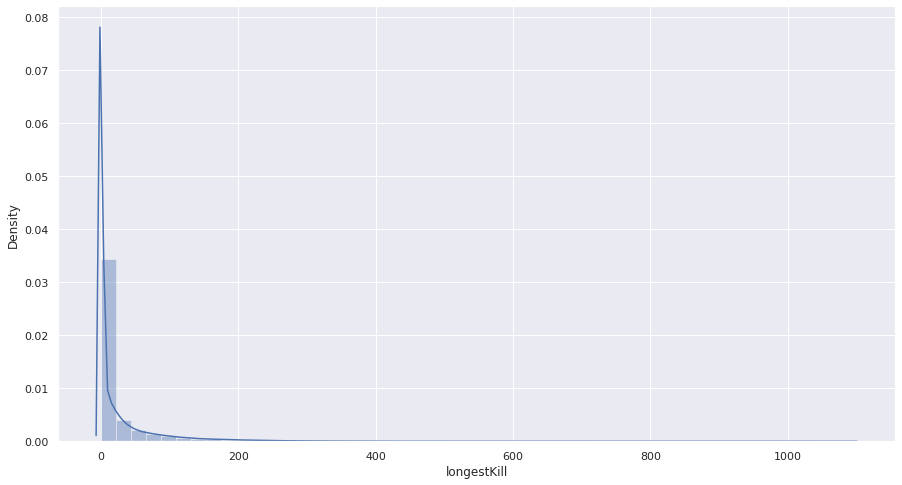

In [41]:
show_distplot('longestKill')

In [42]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
195021,f141f7e776138b,a0fa42bf37e9f0,0b4c9543bc9199,1,4,784.00,5,4,5,4,...,0.0000,0,0,3678.000000,5,1523,0.848633,9928.000000,1.000000,False
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,784.00,5,1,1,5,...,0.0000,0,1,3052.000000,9,0,0.923340,3776.000000,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.00,8,5,7,18,...,0.0000,0,0,48.875000,38,1500,0.538574,48.875000,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.00,0,0,0,9,...,0.0000,0,0,1264.000000,26,0,1.000000,2980.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.00,17,5,0,3,...,0.0000,0,0,29.203125,30,1500,0.600098,29.203125,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.75,0,0,0,51,...,0.0000,0,0,1074.000000,22,0,0.000000,3158.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.00,11,5,0,5,...,0.0000,0,0,569.500000,18,0,0.909180,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.25,0,0,2,45,...,0.0000,0,0,832.500000,9,1500,0.285645,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.00,0,7,0,1,...,0.0000,0,0,2848.000000,4,1500,0.941406,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2104.00,0,4,11,11,...,0.0000,0,0,235.250000,41,0,0.500000,235.250000,0.173913,False


In [43]:
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

#**It is easily inferrable that no world quality sniper users also can take a headshot at distance > 1000 metres. So, these are anomalies.**

In [44]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,5.296875,0,0,1277.0,0,1371,0.428711,1282.0,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.000000,0,0,816.5,5,1533,0.471191,4936.0,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,0.000000,0,0,3150.0,4,1568,1.000000,5876.0,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.000000,0,0,1041.0,10,1606,0.939941,7852.0,0.277778,False


In [45]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving


**We can see the result of our Data-Cleaning Above**

#**Abnormal Number Of Road-Kills**


In [46]:
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,5.296875,0,0,1277.0,0,1371,0.428711,1282.0,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.000000,0,0,816.5,5,1533,0.471191,4936.0,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,0.000000,0,0,3150.0,4,1568,1.000000,5876.0,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.000000,0,0,1041.0,10,1606,0.939941,7852.0,0.277778,False


In [47]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

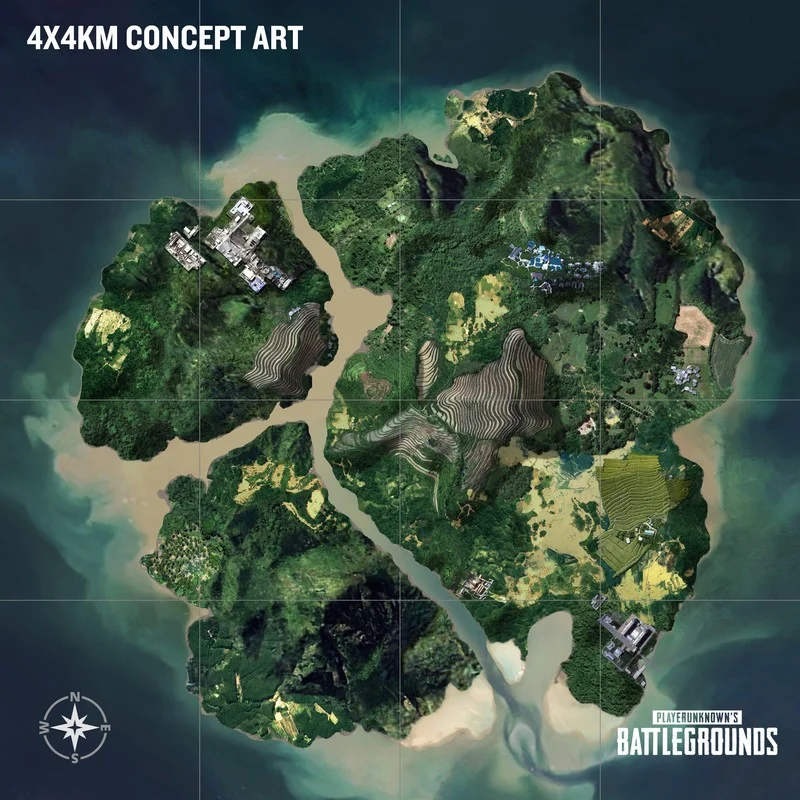

In [48]:
train[['walkDistance', 'rideDistance', 'swimDistance']].describe()

,walkDistance,rideDistance,swimDistance
count,4445396.000,4.445396e+06,4445396.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,0.000,0.000000e+00,0.0
25%,155.375,0.000000e+00,0.0
50%,686.500,0.000000e+00,0.0
75%,1977.000,2.606201e-01,0.0
max,25776.000,4.070400e+04,3824.0


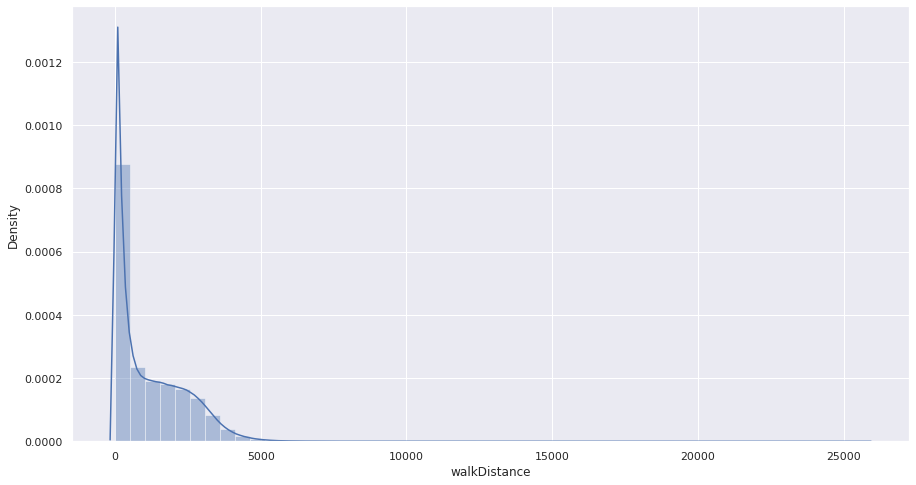

In [49]:
show_distplot('walkDistance')

In [50]:
#People having travelled more than 15,000 kilometres are there to simply roam around and explore places without killing anyone and the anomaly
# is that no person can walk this much distance

train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.0000,0,0,0,44,...,9.882812,0,0,13528.0,7,0,0.816406,13536.0,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.0000,0,0,0,46,...,382.000000,0,0,25776.0,0,0,0.989258,26160.0,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.0000,0,0,5,50,...,15.273438,1,0,13040.0,4,0,0.678711,13056.0,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.0000,0,0,27,41,...,80.312500,0,0,13160.0,3,0,0.964355,13240.0,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.0000,0,0,0,44,...,180.750000,0,0,13360.0,4,0,0.964355,14800.0,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.0000,0,0,0,55,...,129.375000,0,0,16248.0,3,0,0.600098,16376.0,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.0000,0,0,3,48,...,257.000000,0,0,14248.0,8,0,0.799805,15352.0,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.0000,0,0,5,46,...,389.500000,0,0,15368.0,7,0,0.812500,15760.0,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.3750,0,0,0,40,...,42.187500,0,0,13072.0,4,0,0.928711,14904.0,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.0000,0,0,2,39,...,38.437500,0,0,13664.0,1,0,0.891113,13704.0,0.0,False


In [54]:
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

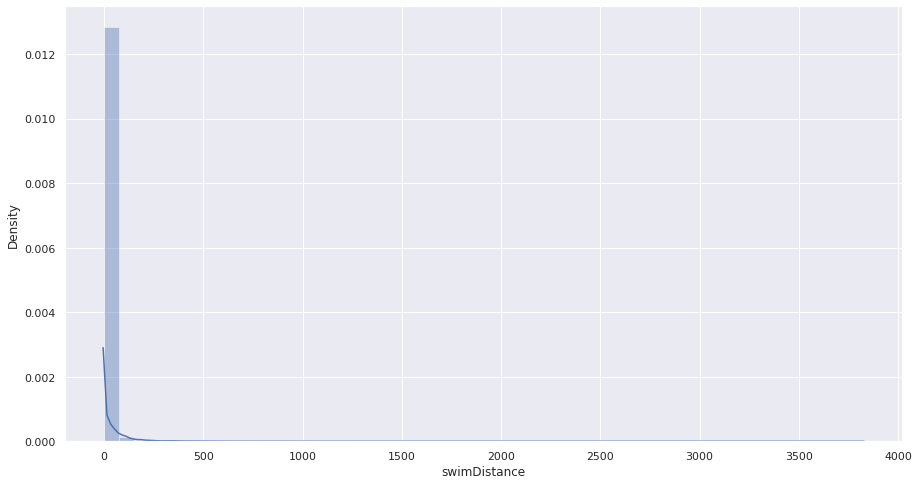

In [55]:
show_distplot('swimDistance')

In [68]:
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

#**Weapons Acquired**
Most of the people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

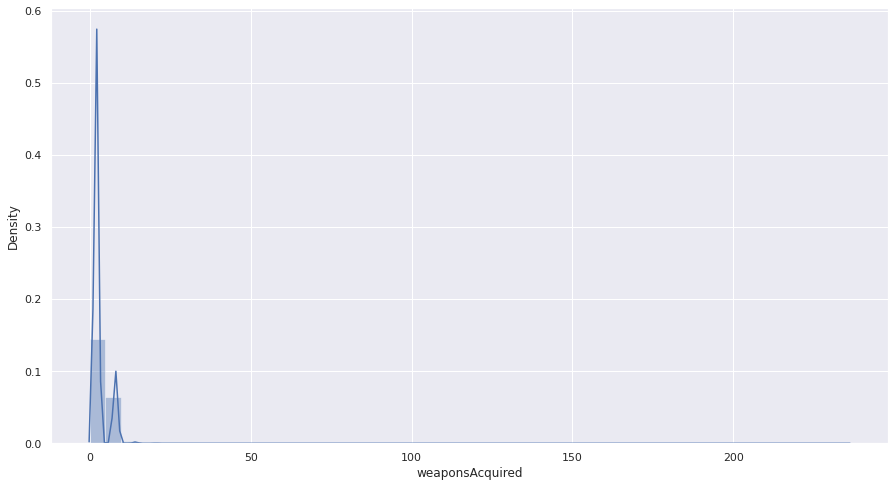

In [69]:
show_distplot('weaponsAcquired')

In [70]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(21, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.125,0,0,0,44,...,0.00000,0,0,1307.0,128,1577,0.710938,3188.0,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.250,1,0,2,48,...,0.00000,0,0,1687.0,80,0,0.750000,1687.0,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000,0,0,0,24,...,47.21875,0,0,2400.0,102,0,0.893066,5300.0,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000,0,0,0,54,...,0.00000,0,0,653.0,95,0,0.560059,653.0,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5376.000,0,8,4,3,...,0.00000,0,0,1128.0,83,0,0.799805,2082.0,0.150943,False


In [71]:
# Remove Outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

#**Anomalies In Heals**

Most players have 5 healing items or less. We can again recognize some weird anomalies.

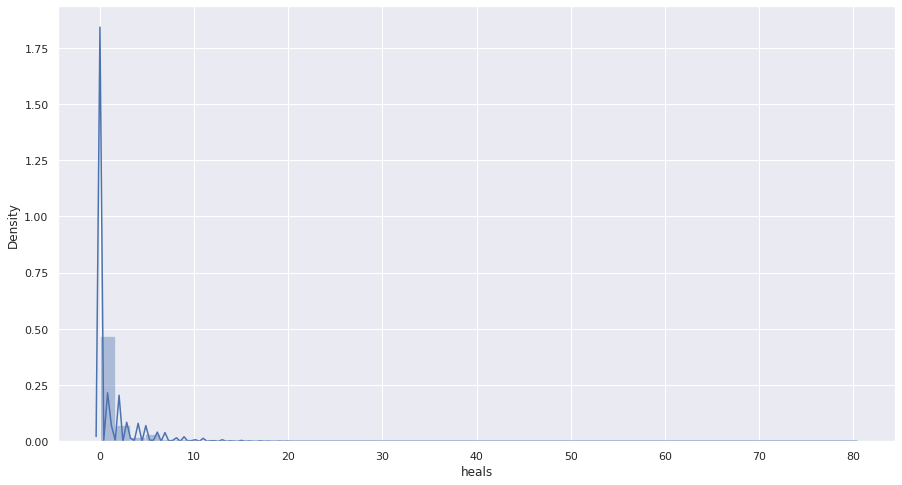

In [72]:
show_distplot('heals')

In [73]:
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.000000,0,0,1387.00,6,0,0.937012,6856.00,0.000000,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,292.500000,0,0,2792.00,7,0,0.961426,3084.00,1.000000,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,3.443359,0,0,1340.00,3,1543,0.833496,1343.00,0.000000,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.000000,0,0,1510.00,6,0,0.864746,7448.00,0.000000,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.000000,0,0,1968.00,9,0,0.836914,5816.00,0.000000,False
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,...,0.000000,0,0,2440.00,2,1511,0.925781,2440.00,0.000000,False
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,...,0.000000,0,0,2252.00,8,0,0.827637,4848.00,0.000000,False
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,...,0.000000,0,0,2928.00,3,1562,0.935547,3416.00,1.000000,False
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,...,0.000000,0,0,268.75,33,1500,0.888672,268.75,0.296296,False
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,...,0.000000,0,0,2488.00,6,1517,0.962891,4928.00,0.250000,False


In [74]:
train.drop(train[train['heals'] >= 40].index, inplace=True)

#**Should we remove all these outliers from our dataset or not?**
We can have a million of rows. So we can afford to loose thousands of rows to create a better model. Their is no predefined process to come across the accurateness of the algorithm.

In [76]:
train.shape

(4445217, 32)

In [78]:
train.to_csv('/content/drive/My Drive/pubg-finish-placement-prediction/cleaned_data.csv')

In [80]:
cleaned_data = pd.read_csv('/content/drive/My Drive/pubg-finish-placement-prediction/cleaned_data.csv')
cleaned_data = reduce_mem_usage(cleaned_data)

Memory usage of dataframe is 1089.50 MB
Memory usage after optimization is: 490.13 MB
Decreased by 55.0%


#**Feature Engineering**
Addition/Removal Of Few New features and finding their Correlation with the WinPlacePercentile


*   Creation of a new variable that gives us or updates us with the number of players joined in the game.



In [81]:
cleaned_data.head()

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
0,0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,...,0.000000,0,0,244.75,1,1466,0.444336,244.75,0.0,0.0
1,1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,...,11.039062,0,0,1434.00,5,0,0.640137,1445.00,0.0,0.0
2,2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,...,0.000000,0,0,161.75,2,0,0.775391,161.75,0.0,0.0
3,3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,...,0.000000,0,0,202.75,3,0,0.166748,202.75,0.0,0.0
4,4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,...,0.000000,0,0,49.75,2,0,0.187500,49.75,0.0,0.0


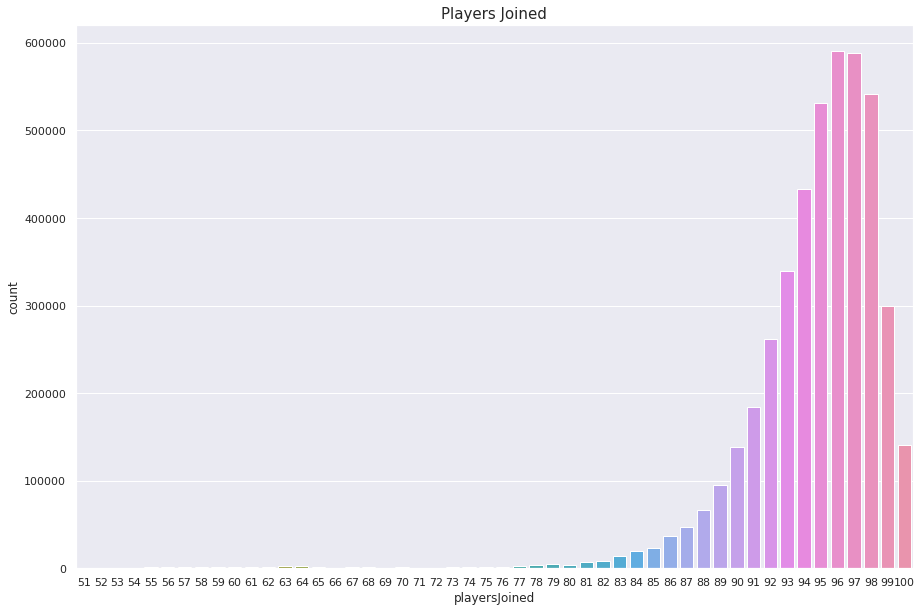

In [86]:
cleaned_data['playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['playersJoined'] > 50]
plt.figure(figsize = (15,10))
sns.countplot(data['playersJoined'])
plt.title('Players Joined', fontsize=15)
plt.show()

##Most of the matches have around 100 or more players and it ranges from 76 to around 100 players

In [91]:
#Normalizing the Features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['playersJoined'])/100 + 1)
#Comparison between the features
to_show = ['Id', 'kills', '_killsNorm', 'damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]

,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.500000,99.735000,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000000,69.360000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.906250,35.867812,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000000,103.000000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000000,105.000000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.539062,8.880625,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.593750,53.141562,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.281250,38.399687,29,29.87,1930,1987.90


##Comparison Of Each Feature and It's Normalised Value on the right

In [94]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killsPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killsPlacePerc,_walkDistancePerc,_damageDealtPerc,walkPerc_killsPerc,_walkPerc_killsPerc
0,0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,...,0.00,0.000000,29.12,1358.24,0.302083,0.625000,0.479167,0.156250,1.586207,1.586207
1,1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,...,0.00,99.735000,28.34,1936.93,0.252747,0.626374,0.560440,0.439560,2.217391,2.217391
2,2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,...,0.00,69.360000,51.00,1344.36,0.290816,0.479592,0.377551,0.448980,1.298246,1.298246
3,3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,...,0.00,35.867812,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,0.840000
4,4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,...,1.03,103.000000,99.91,1466.72,0.670103,0.463918,0.206186,0.577320,0.307692,0.307692
